In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from torch.nn import functional as F
import configparser
import pandas as pd 

import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from os.path import join as oj
sys.path.insert(0, "../src")
from unet import UNet
import my_data
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
fig_path =config['PATHS']['figure_path'] 


In [10]:
# need exp with no active learning
# need exp with prop increasingf
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()


results.reset_index(inplace=True)

results[['foldername',  'cost_function', 'add_ratio',  'final_dice_score', 
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','add_ratio', 
         'foldername' ]).mean()


final_dice_score
experiment_name      cost_function add_ratio foldername                    
BActiveLearning      cut_off_cost  0.020     lno_halfHour             0.977
                                   0.040     lno_halfHour             0.981
                                   0.050     lno_halfHour             0.982
                                   0.080     lno_halfHour             0.983
                                   0.100     lno_halfHour             0.981
                     random_cost   0.020     lno_halfHour             0.975
                                   0.040     lno_halfHour             0.979
                                   0.050     lno_halfHour             0.978
                                   0.080     lno_halfHour             0.980
                                   0.100     lno_halfHour             0.981
BFullDatasetTraining random_cost   0.000     lno                      0.985
BNoActiveLearning    random_cost   0.000     lno_halfHour             0.966

C:\Users\lauri\AppData\Local\Temp\ipykernel_18556\3198401548.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Random'] = results[results.cost_function == 'random_cost'][results.add_ratio == .04].test_dice_score
C:\Users\lauri\AppData\Local\Temp\ipykernel_18556\3198401548.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Active Learning'] = results[results.cost_function == 'cut_off_cost'][results.add_ratio == .04].test_dice_score


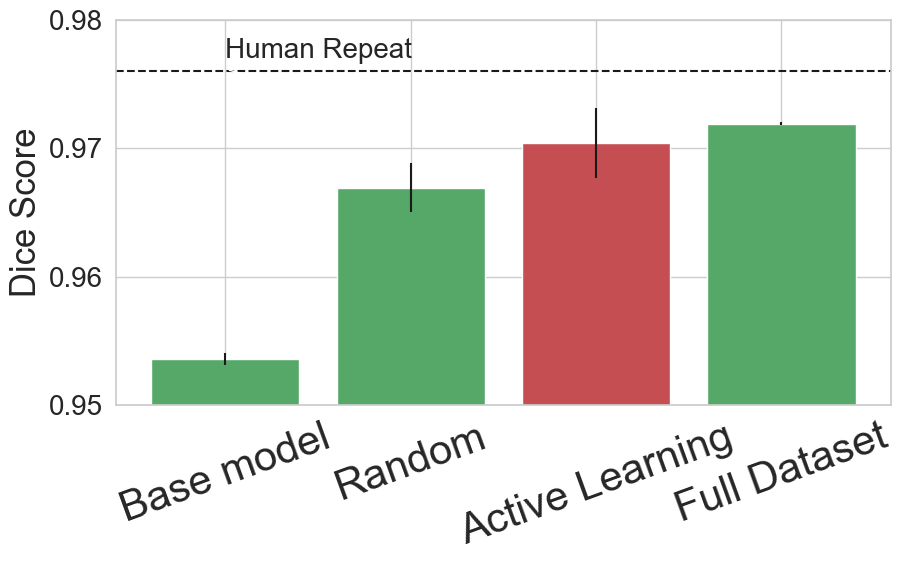

In [112]:
# make figure barplot
results_dict ={}
results_dict['Base model'] = results[results.experiment_name == 'BNoActiveLearning'].test_dice_score
results_dict['Random'] = results[results.cost_function == 'random_cost'][results.add_ratio == .04].test_dice_score
results_dict['Active Learning'] = results[results.cost_function == 'cut_off_cost'][results.add_ratio == .04].test_dice_score
results_dict['Full Dataset'] = results[results.experiment_name == 'BFullDatasetTraining'].test_dice_score
# results_dict['Human repeat'] = np.asarray([0.9761262536048889])
for key in results_dict:
    results_dict[key] = np.asarray(results_dict[key])
# make barplot
plt.figure(figsize=(10,5))
plt.bar(results_dict.keys(), 
        [np.mean(results_dict[key]) for key in results_dict.keys()], 
        yerr=[np.std(results_dict[key])/np.sqrt(len(results_dict[key])) for key in results_dict.keys()],
        # color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        color = ['g', 'g', 'r','g',])
# ticks
plt.xticks(fontsize=30, rotation=20)
plt.yticks([ 0.95, 0.96, 0.97, 0.98], fontsize=20)
plt.axhline(0.976, color='k', linestyle='--', label ='Human Repeat',)
# an arrow that points to the human repeat score and says "human repeat"
plt.annotate('Human Repeat', xy=(0, 0.976), xytext=(0, 0.977), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20)

plt.ylim(0.95, 0.98)
plt.ylabel('Dice Score', fontsize=25)

# plt.legend(loc = 'center left', fontsize=20) 
plt.savefig(oj(fig_path, 'results_dice.pdf'), dpi=300, bbox_inches='tight')

<Figure size 1000x500 with 0 Axes>

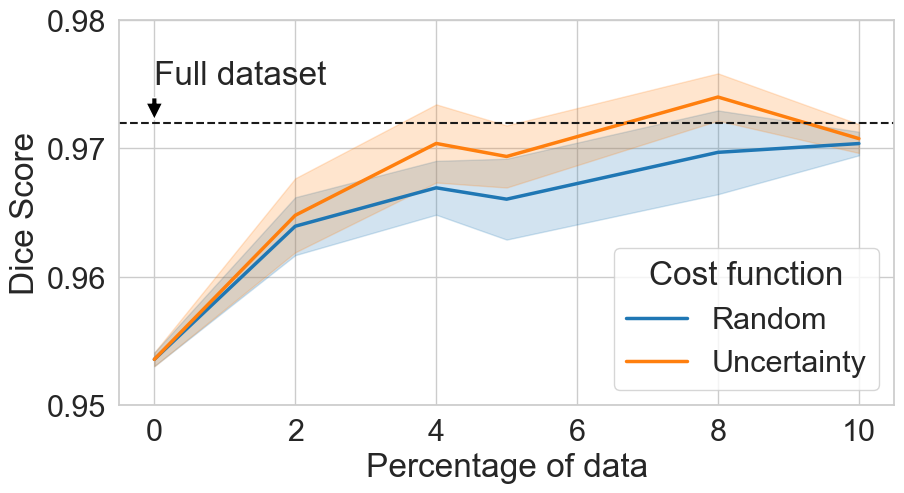

In [13]:
import seaborn as sns
#lineplot
results_here = results[results.experiment_name != 'BFullDatasetTraining']

results_here_copy = results_here[results_here.add_ratio ==.0].copy()
# change the ratio from .0 to .01 only if it is .0

results_here_copy.cost_function = 'cut_off_cost'
results_here = pd.concat([results_here, results_here_copy])
plt.figure(figsize=(10,5))
#rename 
results_here.cost_function = results_here.cost_function.replace('cut_off_cost', 'Uncertainty')
results_here.cost_function = results_here.cost_function.replace('random_cost', 'Random')
#make matplotlib
# results_here = results_here[results_here.add_ratio < .1]
plt.figure(figsize=(10,5))

#rename column
results_here = results_here.rename(columns={'test_dice_score': 'Dice Score'})
results_here.add_ratio = results_here.add_ratio*100
results_here = results_here.rename (columns={'add_ratio': 'Percentage of data'})

results_here = results_here.rename(columns={'cost_function': 'Cost function'})
# results_here = results_here.rename(columns={'add_ratio': '% of Dataset'})

#increase font size for seaborm
sns.set(font_scale=2)
sns.set_style("whitegrid")
# sns.despine(offset=10, trim=True);
# g_results = sns.lineplot(data=results_here, x="% of Dataset", y="Dice Score", hue="Cost function", errorbar='se', palette="tab10", linewidth=2.5)

g_results = sns.lineplot(data=results_here, x="Percentage of data", y="Dice Score", hue="Cost function", errorbar='se', palette="tab10", linewidth=2.5)

plt.ylim(.95, .98)
plt.axhline(0.972, color='k', linestyle='--', label ='Full dataset',)
# an arrow that points to the h line and says "Full dataset"
plt.annotate('Full dataset', xy=(0, 0.972), xytext=(0, 0.975), arrowprops=dict(facecolor='black', shrink=0.1),)
# savefig
plt.savefig(oj(fig_path, 'results_lineplot.pdf'), dpi=300, bbox_inches='tight')